### Imports

In [1]:
import numpy as np
import sys
# Importing standard Qiskit libraries
from qiskit import *
from qiskit.tools.jupyter import *
from qiskit.circuit.library.standard_gates import SXGate, SXdgGate
from qiskit.visualization import *
#from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### Load backend

In [43]:
IBMQ.providers()

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='q-summer-school', group='main', project='project-4')>]

In [44]:
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_oslo') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [45]:
backend = provider.get_backend('simulator_mps')

### V Gate

In [46]:
CV = SXGate().control(1)
CVdg = SXdgGate().control(1)

### Peres Gate

In [47]:
qc = QuantumCircuit(3, name='Peres Gate')
qc.append(CVdg, [0,2])
qc.append(CVdg, [1,2])
qc.cnot(0,1)
qc.append(CV, [1,2])
qc.draw('mpl')
PeresGate = qc.to_instruction()

### TR Gate

In [48]:
qc = QuantumCircuit(3, name='TR Gate')
qc.append(CVdg, [1,2])
qc.cnot(0,1)
qc.append(CV, [0,2])
qc.append(CV, [1,2])
qc.draw('mpl')
TRGate = qc.to_instruction()

#### Carry Look-ahead adder

In [49]:
def adder(n):

    a = QuantumRegister(n)
    b = QuantumRegister(n)
    zg = QuantumRegister(n)
    zp = QuantumRegister(n-3)

    qc = QuantumCircuit(a,b,zg,zp)

    # Step 1
    for i in range(n):
        qc.append(PeresGate, [a[i], b[i], zg[i]])


    #Step 2
    qc.toffoli(b[2:n-1:2], b[3:n:2], zp[:n-3:2])
    qc.toffoli(zg[0:n-1:2], b[1:n:2], zg[1:n:2])

    # Step 3
    qc.toffoli(zg[1], zp[0], zg[3])
    qc.toffoli(zg[n//2+1], zp[n//2], zg[n//2+3])
    qc.toffoli(zp[n//2-2], zp[n//2], zp[n//2-1])

    # Step 4
    qc.toffoli(zg[n-5], zp[n-6], zg[n-3])
    qc.toffoli(zg[n-5], zp[n-5], zg[n-1])

    # Step 5
    qc.toffoli(zg[1:n-2:2], b[2:n-1:2], zg[2:n-1:2])
    qc.toffoli(zp[n//2-2], zp[n//2], zp[n//2-1])

    # Step 6
    qc.toffoli(b[2:n-1:2], b[3:n:2], zp[0:n-3:2])

    # Step 7
    qc.cnot(zg[0:n-1], b[1:n])


    # Step 8
    qc.x(b)

    # Step 9
    qc.cnot(a[1:], b[1:])

    # Step 10
    qc.toffoli(b[2:n-1:2], b[3:n:2], zp[0:n-3:2])

    # Step 11
    qc.toffoli(zg[1:n-2:2], b[2:n-1:2], zg[2:n-1:2])
    qc.toffoli(zp[n//2-2], zp[n//2], zp[n//2-1])

    # Step 12
    qc.toffoli(zg[n-5], zp[n-6], zg[n-3])
    qc.toffoli(zg[n-5], zp[n-5], zg[n-1])

    # Step 13
    qc.toffoli(zg[1], zp[0], zg[3])
    qc.toffoli(zg[n//2+1], zp[n//2], zg[n//2+3])

    # Step 14
    qc.toffoli(zg[0:n-1:2], b[1:n:2], zg[1:n:2])
    qc.toffoli(zp[n//2-2], zp[n//2], zp[n//2-1])

    # Step 15
    qc.toffoli(b[2:n-1:2], b[3:n:2], zp[0:n-3:2])

    # Step 16
    qc.toffoli(a[0], b[0], zg[0])
    for i in range(1,n):
        qc.append(TRGate, [a[i], b[i], zg[i]])

    # Step 17
    qc.x(b)
    
    return qc

#### Subtractor Circuit
Computes b-a

In [54]:
def subtractor(n):
    a = QuantumRegister(n)
    b = QuantumRegister(n)
    zg = QuantumRegister(n)
    zp = QuantumRegister(n-3)

    qc = QuantumCircuit(a,b,zg,zp)
    
    # Complement b
    qc.x(b)

    # Append adder circuit
    adder_circ = adder(n)
    qc.append(adder_circ, a[:] + b[:] + zg[:] + zp[:])
    
    # Complement b -> Now b stores b-a
    qc.x(b)
    
    return qc

### Adder-Subtractor Circuit
If ctrl is low, it computes b+a<br/>
Else it computes b-a

In [57]:
def adder_subtractor(n):
    
    ctrl = QuantumRegister(1)
    a = QuantumRegister(n)
    b = QuantumRegister(n)
    zg = QuantumRegister(n)
    zp = QuantumRegister(n-3)

    qc = QuantumCircuit(ctrl,a,b,zg,zp)
    
    # Complement b
    qc.cx(ctrl, b)

    # Append adder circuit
    adder_circ = adder(n)
    qc.append(adder_circ, a[:] + b[:] + zg[:] + zp[:])
    
    # Complement both a and b -> b stores b-a if ctrl is high
    qc.cx(ctrl, b)
    
    return qc

### Controlled Adder

In [58]:
def ctrl_add(n):
    """This function takes the value n, which is the number of bits required to represent a or b and returns
    the conditional adder circuit for them"""
    
    # Defining the Registers for CTRL a and b.
    qr = QuantumRegister(1, name = "ctrl")
    qr_b = QuantumRegister(n, name = "b")
    qr_a = QuantumRegister(n, name = "a")
    
    # The quantum circuit
    qc = QuantumCircuit(qr, qr_a, qr_b)
    
    # The corresponding gates:
    qc.cx(qr_a[1:], qr_b[1:])
        
        
    for j in range(n-1,1,-1):
        qc.cx(qr_a[j-1], qr_a[j])
        
    qc.toffoli(qr_b[:n-1],qr_a[:n-1],qr_a[1:])
        
    for p in range(n-1, 0, -1):
        qc.toffoli(qr,qr_a[p],qr_b[p])
        qc.toffoli(qr_b[p-1],qr_a[p-1],qr_a[p])
        
    qc.toffoli(qr,qr_a[0], qr_b[0])
    
    
    qc.cx(qr_a[1:n-1], qr_a[2:])
    
    qc.cx(qr_a[1:], qr_b[1:])
    
    return qc

### MODULO CIRCUIT

In [59]:
def modulo(a,b,n):
    qr_b = QuantumRegister(n, name='b')
    qr_R = QuantumRegister(n-1, name='r')
    qr_Q = QuantumRegister(n, name='q')
    qr_zg = QuantumRegister(n)
    qr_zp = QuantumRegister(n-3)
    cr = ClassicalRegister(n-1)
    cq = ClassicalRegister(n)
    
    sub_circ = subtractor(n)
    add_sub_circ = adder_subtractor(n)
    ctrl_adder_circ = ctrl_add(n-1)
    
    qc = QuantumCircuit(qr_b, qr_R, qr_Q, qr_zg, qr_zp, cr, cq)
    
    # initialize ciruciit with input
    b.reverse()
    a.reverse()
    for i, bi in enumerate(b):
        if bi:
            qc.x(qr_b[i])
    
    for i, ai in enumerate(a[:-1]):
        if ai:
            qc.x(qr_R[i])
            
    if a[-1]:
        qc.x(qr_Q[0])
        
    
    # Modulo circuit
    qc.append(sub_circ, qr_b[:] + qr_Q[:] + qr_zg[:] + qr_zp[:])
    
    for i in range(n-1):
        qc.x(qr_Q[n-i-1])
#         print(len(qr_R[n-i-2:]), len(qr_Q[0:n-i-1]))
        qc.append(add_sub_circ, [qr_Q[n-i-1]] + qr_b[:] + qr_R[n-i-2:] + qr_Q[0:n-i-1] + qr_zg[:] + qr_zp[:])
        
    qc.append(ctrl_adder_circ, [qr_Q[0]] + qr_b[:-1] + qr_R[:])
    qc.x(qr_Q[0])
    
    qc.measure(qr_R, cr)
    qc.measure(qr_Q, cq)
    
    return qc
    

In [74]:
def dec_to_bin(N,p):
    N_b = list(bin(N).replace("0b", ""))
    p_b = list(bin(p).replace("0b", ""))
    
    L_N = [int(x) for x in N_b]
    L_p = [int(x) for x in p_b]
    
    m = len(L_N) + 2
    for i in range(m-len(L_N)):
        L_N = [0] + L_N
        
    for j in range(m-len(L_p)):
        L_p = [0] + L_p
            
    return (L_N, L_p, m)



def info_circ(qc):
    q = qc.num_qubits
    c = qc.num_clbits
    d = qc.depth()
    g = dict(qc.count_ops())
    return (q,c,d,g)


N_ = int(input("N value: "))
p_ = int(input("p value: "))
N, p, m = dec_to_bin(N_, p_)
print(N,p,m)
qc_ = modulo(N,p,m)
qc = transpile(qc_  , basis_gates=['u3', 'cx'])
num_qubits, num_clbits, depth, num_gates = info_circ(qc)
print("The number of qubits in the circuit is: ", num_qubits)
print("The number of classical bits in the circuit is: ", num_clbits)
print("The  depth the circuit is: ", depth)
print("The number of cx and u3 gates in the circuit is: ", num_gates)

N value: 32
p value: 4
[0, 0, 1, 0, 0, 0, 0, 0] [0, 0, 0, 0, 0, 1, 0, 0] 8
The number of qubits in the circuit is:  36
The number of classical bits in the circuit is:  15
The  depth the circuit is:  1837
The number of cx and u3 gates in the circuit is:  {'u3': 4996, 'cx': 3792, 'measure': 15}


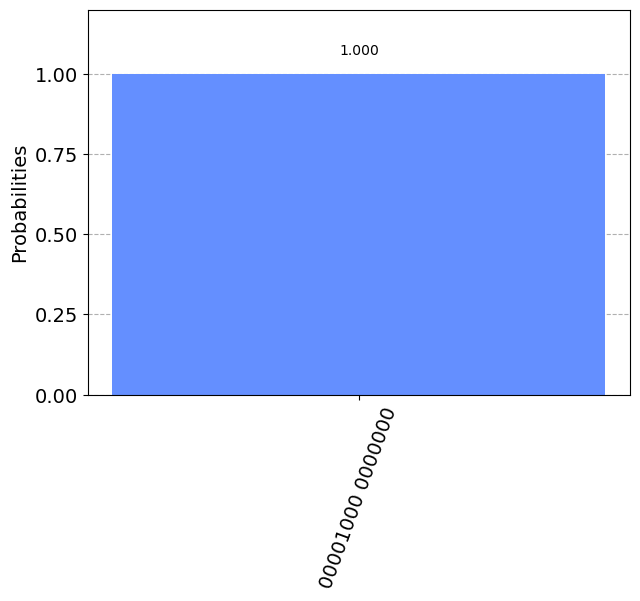

In [75]:
job = execute(qc_, backend, shots=1024)
counts = job.result().get_counts()
plot_histogram(counts)